# Weather Model Training Notebook (Improved)

This notebook implements an improved training pipeline for weather prediction models. 
**Key Improvements:**
- **Time-Series Feature Engineering:** Adds lag features (previous hour, previous day) and rolling means to capture temporal dependencies.
- **Time-Based Splitting:** Splits data chronologically (Training < 2020, Testing >= 2020) to realistically simulate future prediction.

## 1. Environment Setup and Library Loading

**Goal:** Import necessary libraries for data processing, model training, evaluation, and visualization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings

warnings.filterwarnings('ignore')
print("Libraries imported successfully.")

Libraries imported successfully.


## 2. Data Collection and Loading

**Goal:** Load the historical dataset.
**Source:** `../../data_collections/datasets/historical_data_hourly.csv`

In [2]:
# Load dataset
file_path = '../../data_collections/datasets/historical_data_hourly.csv'
df = pd.read_csv(file_path)

# Display first few rows and info
print(f"Total records: {len(df)}")
display(df.head())
display(df.info())

Total records: 227280


,id,hour,day,month,year,temp,humidity,windspeed,sealevelpressure,weather_code,conditions
0,0,0,1,1,2000,21.8,98,4.0,1008.4,3,Overcast
1,1,1,1,1,2000,21.4,99,4.0,1007.9,3,Overcast
2,2,2,1,1,2000,21.4,98,3.2,1007.4,3,Overcast
3,3,3,1,1,2000,21.2,99,4.6,1007.0,3,Overcast
4,4,4,1,1,2000,21.0,99,3.6,1006.9,3,Overcast


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227280 entries, 0 to 227279
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                227280 non-null  int64  
 1   hour              227280 non-null  int64  
 2   day               227280 non-null  int64  
 3   month             227280 non-null  int64  
 4   year              227280 non-null  int64  
 5   temp              227280 non-null  float64
 6   humidity          227280 non-null  int64  
 7   windspeed         227280 non-null  float64
 8   sealevelpressure  227280 non-null  float64
 9   weather_code      227280 non-null  int64  
 10  conditions        227280 non-null  object 
dtypes: float64(3), int64(7), object(1)
memory usage: 19.1+ MB


None

## 3. Data Preprocessing

**Goal:** Clean, standardize, and prepare data for regression training.
**Steps:**
- Format date/time
- Label Encode categorical variables
- **New:** Feature Engineering (Lags & Rolling Means)

In [3]:
# Construct timestamp
if {'year', 'month', 'day', 'hour'}.issubset(df.columns):
    df['timestamp'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
elif 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort by time to ensure correct lag generation
df = df.sort_values('timestamp').reset_index(drop=True)

# Rename columns
column_mapping = {
    'temp': 'temperature',
    'windspeed': 'wind_speed',
    'sealevelpressure': 'pressure'
}
df = df.rename(columns=column_mapping)

# Label Encoding for 'conditions'
le = LabelEncoder()
if 'conditions' in df.columns and df['conditions'].dtype == 'object':
    df['condition_encoded'] = le.fit_transform(df['conditions'])
    print("Encoded 'conditions' to 'condition_encoded'")

# Add Time Features
df['hour'] = df['timestamp'].dt.hour
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day

print("Basic preprocessing complete.")

Encoded 'conditions' to 'condition_encoded'
Basic preprocessing complete.


## 4. Model Training and Comparison (Improved)

**Goal:** Train and compare models using **Time-Series Split** and **Lag Features**.
**Target:** Temperature (as representative).
**Split Strategy:** Train on data < 2020, Test on data >= 2020.

In [4]:
def create_lag_features(data, target_col, lags=[1, 2, 3, 24], window=24):
    df_feat = data.copy()
    for lag in lags:
        df_feat[f'{target_col}_lag_{lag}'] = df_feat[target_col].shift(lag)
    
    # Rolling mean (excluding current timestep to avoid leakage, so shift 1 first)
    df_feat[f'{target_col}_rolling_mean_{window}'] = df_feat[target_col].shift(1).rolling(window=window).mean()
    
    return df_feat.dropna()

# Prepare data for Temperature
target = 'temperature'
df_temp = create_lag_features(df, target)

# Define Features (X) and Target (y)
feature_cols = ['hour', 'month', 'day'] + [c for c in df_temp.columns if 'lag' in c or 'rolling' in c]
if 'condition_encoded' in df_temp.columns:
    feature_cols.append('condition_encoded')

X = df_temp[feature_cols]
y = df_temp[target]

# Time-Based Split
split_date = '2020-01-01'
train_mask = df_temp['timestamp'] < split_date
test_mask = df_temp['timestamp'] >= split_date

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"Training Samples: {len(X_train)}, Testing Samples: {len(X_test)}")

def evaluate_models_timeseries(X_train, y_train, X_test, y_test):
    models = {
        "Linear Regression": LinearRegression(),
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "KNN": KNeighborsRegressor(),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    }
    
    results = []
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        results.append({
            "Model": name,
            "MSE": mse,
            "MAE": mae,
            "RMSE": rmse,
            "R2 Score": r2
        })
        
    return pd.DataFrame(results)

print("Comparing models for Temperature prediction (Time-Series Split)...")
comparison_results = evaluate_models_timeseries(X_train, y_train, X_test, y_test)
display(comparison_results)

Training Samples: 175296, Testing Samples: 51960
Comparing models for Temperature prediction (Time-Series Split)...


,Model,MSE,MAE,RMSE,R2 Score
0,Linear Regression,0.450266,0.469460,0.671019,0.947473
1,Decision Tree,0.442308,0.473100,0.665062,0.948402
2,KNN,0.403547,0.464814,0.635253,0.952924
3,Random Forest,0.253177,0.352267,0.503167,0.970465


## 5. Analysis of Results and Individual Parameter Performance

**Goal:** Evaluate the best model (Random Forest) on all individual parameters using the improved feature engineering pipeline.
**Targets:** Temperature, Humidity, Wind Speed, Pressure.


Optimizing model for temperature...

Optimizing model for humidity...

Optimizing model for wind_speed...

Optimizing model for pressure...


,Parameter,MAE,RMSE,Test R2,Train R2
0,Temperature,0.351057,0.502038,0.970598,0.997090
1,Humidity,2.383942,3.353839,0.956560,0.996027
2,Wind_speed,1.526530,2.072095,0.782642,0.967511
3,Pressure,0.224523,0.291670,0.973242,0.995107


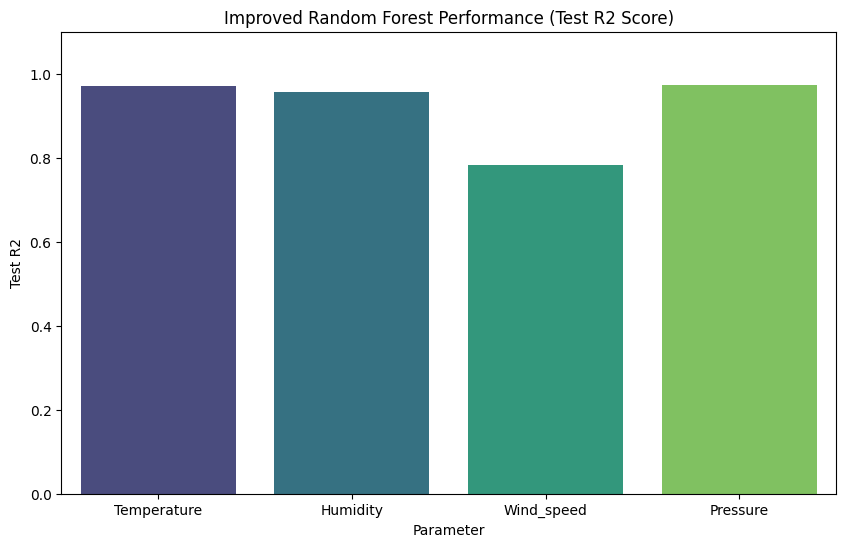

In [5]:
targets = ['temperature', 'humidity', 'wind_speed', 'pressure']
rf_results = []
best_models = {}

# We will store the feature columns used for each target to ensure consistency during inference
model_features = {}

for target in targets:
    print(f"\nOptimizing model for {target}...")
    
    # 1. Create specific features for this target
    df_target = create_lag_features(df, target)
    
    # 2. Define X and y
    feature_cols = ['hour', 'month', 'day'] + [c for c in df_target.columns if 'lag' in c or 'rolling' in c]
    if 'condition_encoded' in df_target.columns:
        feature_cols.append('condition_encoded')
    
    X = df_target[feature_cols]
    y = df_target[target]
    
    # 3. Time-Based Split
    train_mask = df_target['timestamp'] < split_date
    test_mask = df_target['timestamp'] >= split_date
    
    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]
    
    # 4. Train Random Forest
    # Increased n_estimators and max_depth control for better generalization
    rf = RandomForestRegressor(n_estimators=150, max_depth=20, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    best_models[target] = rf
    model_features[target] = feature_cols
    
    # 5. Evaluate
    y_pred_test = rf.predict(X_test)
    y_pred_train = rf.predict(X_train)
    
    mae = mean_absolute_error(y_test, y_pred_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_test = r2_score(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    
    rf_results.append({
        "Parameter": target.capitalize(),
        "MAE": mae,
        "RMSE": rmse,
        "Test R2": r2_test,
        "Train R2": r2_train
    })

rf_results_df = pd.DataFrame(rf_results)
display(rf_results_df)

# Visualizing Performance
plt.figure(figsize=(10, 6))
sns.barplot(x='Parameter', y='Test R2', data=rf_results_df, palette='viridis')
plt.title('Improved Random Forest Performance (Test R2 Score)')
plt.ylim(0, 1.1)
plt.show()

## 6. Saving the Best Model

**Goal:** Save the trained Random Forest models for backend use into a **single file**.

In [6]:
import os

save_dir = '../models'
os.makedirs(save_dir, exist_ok=True)

# Save all models in a single dictionary
filename = f"{save_dir}/weather_prediction_models.pkl"
joblib.dump(best_models, filename)

print(f"Saved all models to {filename}")

Saved all models to ../models/weather_prediction_models.pkl


## 7. Visualization: Actual vs. Predicted

**Goal:** Visualize prediction accuracy for January 2020 (Daily Aggregation).

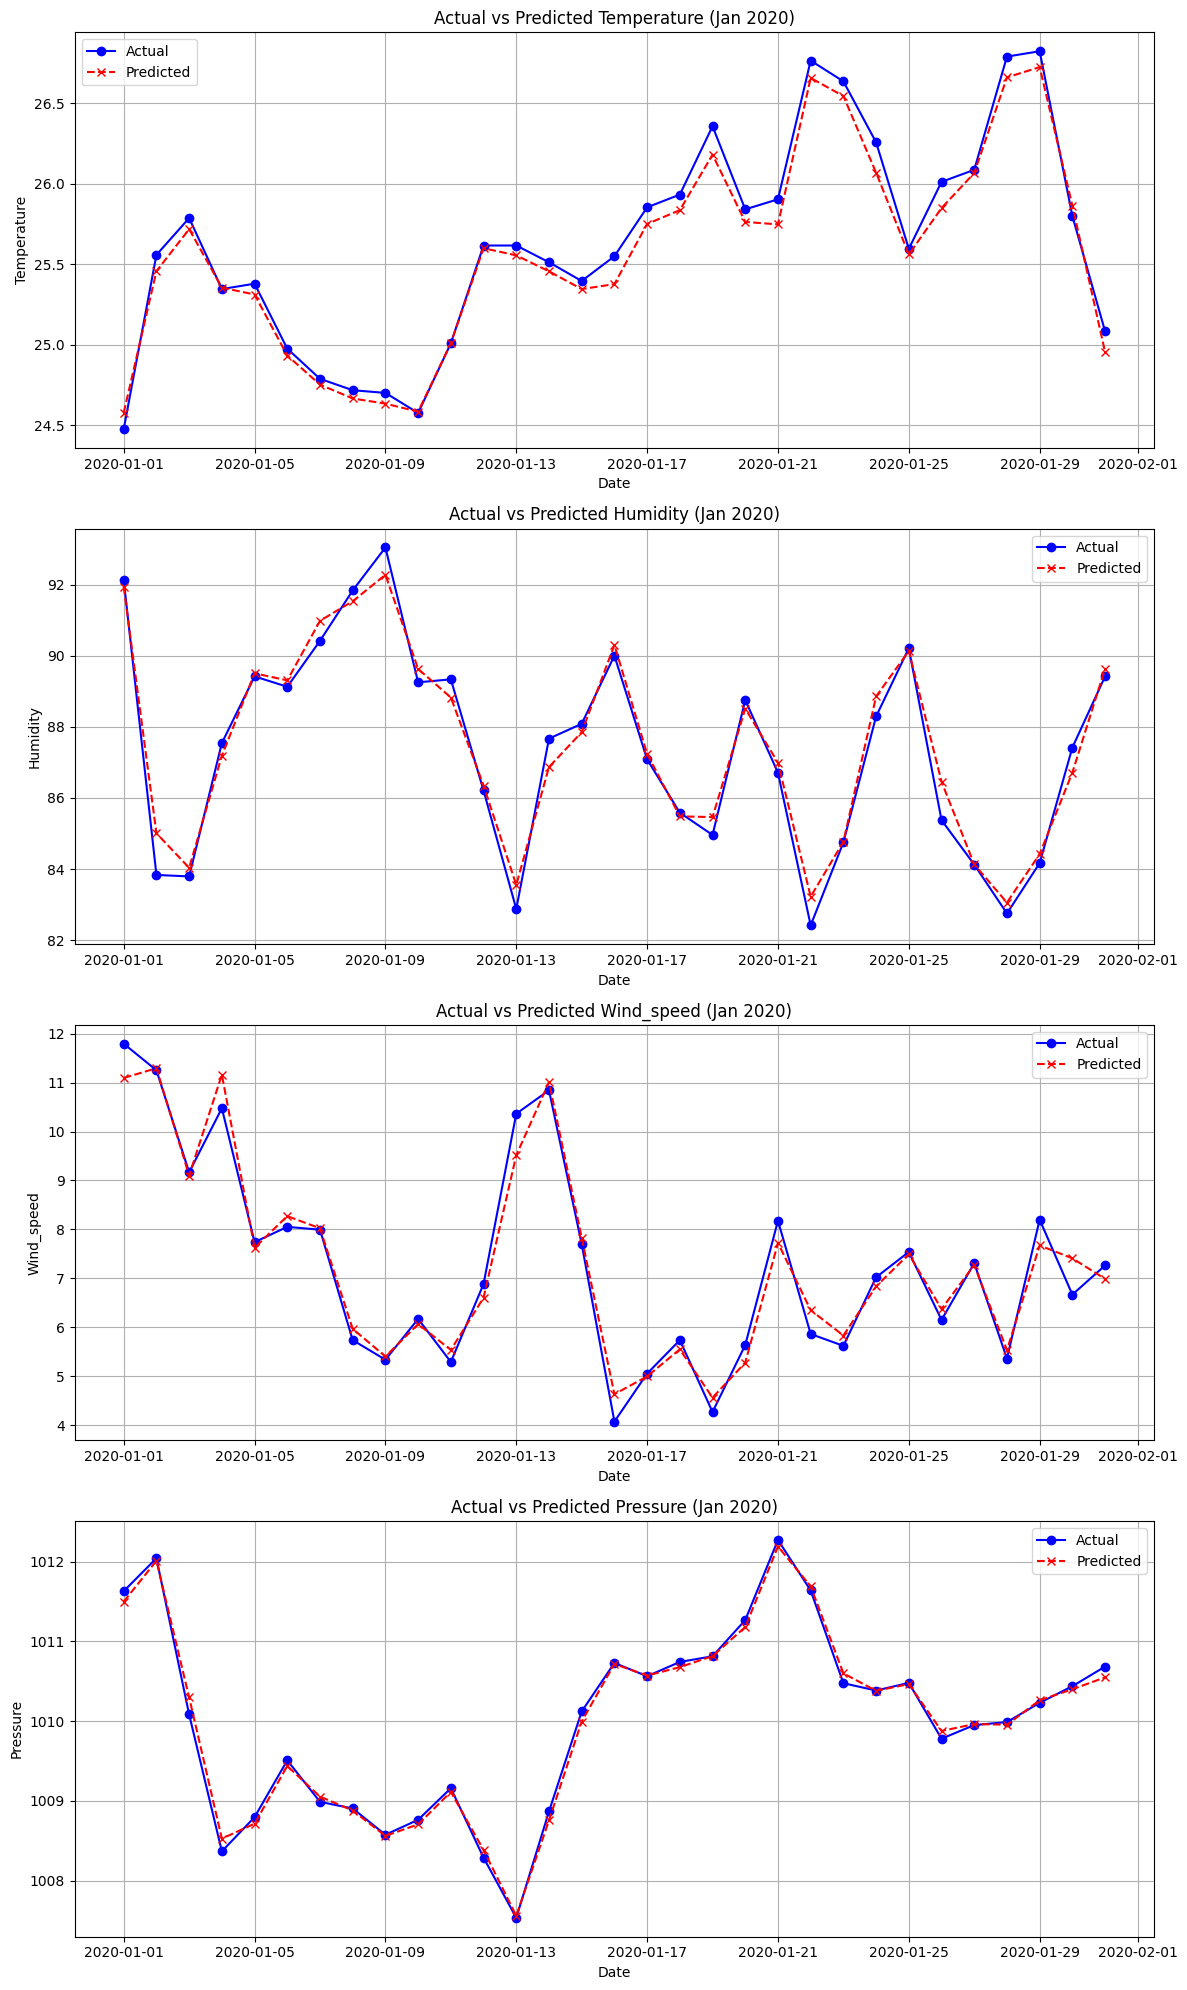

In [7]:
# Filter data for January 2020
# We need to use the data WITH features generated
# Since we generated features per target, we need to handle this carefully for visualization

fig, axes = plt.subplots(4, 1, figsize=(12, 20))

for i, target in enumerate(targets):
    # Re-create features for this target (same as training)
    df_target = create_lag_features(df, target)
    
    # Filter Jan 2020
    jan_2020 = df_target[(df_target['timestamp'].dt.year == 2020) & (df_target['timestamp'].dt.month == 1)].copy()
    
    if len(jan_2020) == 0:
        # Fallback if no 2020 data
        jan_2020 = df_target.iloc[-720:].copy() # Last 30 days approx

    # Prepare X
    X_jan = jan_2020[model_features[target]]
    
    # Predict
    model = best_models[target]
    y_pred = model.predict(X_jan)
    
    # Add prediction to dataframe for resampling
    jan_2020['predicted'] = y_pred
    
    # Resample to Daily for clearer visualization
    daily_data = jan_2020.resample('D', on='timestamp').mean(numeric_only=True)
    
    ax = axes[i]
    ax.plot(daily_data.index, daily_data[target], label='Actual', color='blue', marker='o')
    ax.plot(daily_data.index, daily_data['predicted'], label='Predicted', color='red', linestyle='--', marker='x')
    
    ax.set_title(f'Actual vs Predicted {target.capitalize()} (Jan 2020)')
    ax.set_xlabel('Date')
    ax.set_ylabel(target.capitalize())
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

## 8. Visualization: Incremental Data Impact

**Goal:** Show how R2 score improves with more data points.

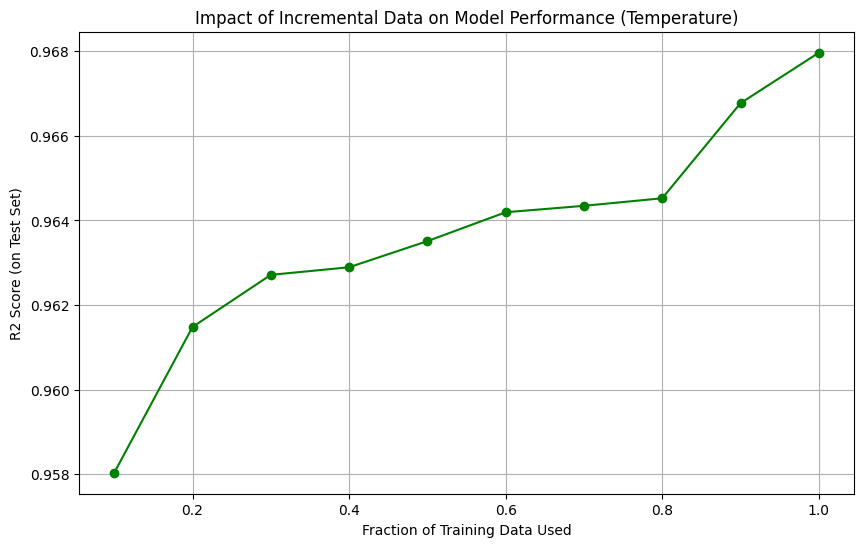

In [8]:
data_fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
r2_scores = []

# Target: Temperature
target = 'temperature'
df_target = create_lag_features(df, target)
X = df_target[model_features[target]]
y = df_target[target]

# Use the same time-split logic, but limit the TRAINING data size
train_mask = df_target['timestamp'] < split_date
test_mask = df_target['timestamp'] >= split_date

X_train_full = X[train_mask]
y_train_full = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

for frac in data_fractions:
    # Take the LAST fraction of training data (most recent history is usually most relevant)
    # Or just random sample from training set. Let's do random sample to simulate "more data volume"
    # regardless of time, but keeping time structure is better. 
    # Let's just take the first N samples to simulate "collecting data over time".
    n_samples = int(len(X_train_full) * frac)
    X_train_sub = X_train_full.iloc[:n_samples]
    y_train_sub = y_train_full.iloc[:n_samples]
    
    rf = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
    rf.fit(X_train_sub, y_train_sub)
    y_pred = rf.predict(X_test)
    
    r2_scores.append(r2_score(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(data_fractions, r2_scores, marker='o', color='green')
plt.title('Impact of Incremental Data on Model Performance (Temperature)')
plt.xlabel('Fraction of Training Data Used')
plt.ylabel('R2 Score (on Test Set)')
plt.grid(True)
plt.show()